In [2]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [4]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 4.16.2


In [5]:
os.chdir("/mnt/batch/tasks/shared/LS_root/mounts/clusters/dscpu/code/Users/Tamilselvan.S/Press Release/Data")
train = pd.read_csv("Cleaned_PR_TD.csv")

In [6]:
train.head()

Category Date of release  \
0  Corporate Information      2021-04-01   
1  Corporate Information      2021-04-01   
2  Corporate Information      2021-04-02   
3               Offering      2021-04-05   
4  Corporate Information      2021-04-06   

                                    Title / Contents          Issued by  \
0  NTT DATA Ranked No. 8 in Brand Finance's Lates...           NTT DATA   
1  Effective April 1, 2021: itelligence | NTT DAT...           NTT DATA   
2  NTT DATA to publish Digital Thought Leadership...           NTT DATA   
3     Transformer Neural Networks are Shaking up AI   NTT DATA Services   
4  NTT DATA Achieves Key AWS Partner Network Mile...  NTT DATA Services   

  Country Language                                        Description  \
0  Global  English  TOKYO – Apr 1, 2021 – NTT DATA, a global digit...   
1  Global  English  March 30, 2021\n itelligence | NTT DATA Busine...   
2  Global  English  TOKYO – Apr 2, 2021 – NTT DATA, a global digit...   
3      US  English  Scott Boettcher, vice president of data intell...   
4      US  English  PLANO, Texas – April 5, 2021 – NTT DATA Servic...   

                                                 URL Marketing Contact  \
0  https://www.nttdata.com/global/en/media/press-...           Amy Baj   
1  https://us.nttdata.com/en/news/press-release/2...           Amy Baj   
2  https://www.nttdata.com/global/en/media/press-...           Amy Baj   
3  https://searchenterpriseai.techtarget.com/feat...           Amy Baj   
4  https://us.nttdata.com/en/news/press-release/2...           Amy Baj   

  E mail for Marketing Contact  Quarter  Unique Count  Company Issued_Short  \
0          amy.baj@nttdata.com  2021 Q1           NaN      NaN  Global (HQ)   
1          amy.baj@nttdata.com  2021 Q1           NaN      NaN  Global (HQ)   
2          amy.baj@nttdata.com  2021 Q1           NaN      NaN  Global (HQ)   
3          amy.baj@nttdata.com  2021 Q1           NaN      NaN     Services   
4          amy.baj@nttdata.com  2021 Q1           NaN      NaN     Services   

                                   Title / Contents1  \
0              ranked 8 brand finances latest report   
1  effective april 1 2021 itelligence business so...   
2      publish digital thought leadership automotive   
3             transformer neural networks shaking ai   
4        achieves key aws partner network milestones   

                                        Description1  
0  tokyo – apr 1 2021 – global digital business s...  
1  march 30 2021 itelligence business solutions i...  
2  tokyo – apr 2 2021 – global digital business s...  
3  scott boettcher vice president intelligence se...  
4  plano texas – april 5 2021 – services global d...

In [7]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [14]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [15]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [16]:
# model_class.pretrained_model_archive_map.keys()

In [17]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [18]:
seed_all(seed)


In [21]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.model_max_length
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [22]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [23]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [24]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [25]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [26]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

In [27]:
train.head(2)

Category Date of release  \
0  Corporate Information      2021-04-01   
1  Corporate Information      2021-04-01   

                                    Title / Contents Issued by Country  \
0  NTT DATA Ranked No. 8 in Brand Finance's Lates...  NTT DATA  Global   
1  Effective April 1, 2021: itelligence | NTT DAT...  NTT DATA  Global   

  Language                                        Description  \
0  English  TOKYO – Apr 1, 2021 – NTT DATA, a global digit...   
1  English  March 30, 2021\n itelligence | NTT DATA Busine...   

                                                 URL Marketing Contact  \
0  https://www.nttdata.com/global/en/media/press-...           Amy Baj   
1  https://us.nttdata.com/en/news/press-release/2...           Amy Baj   

  E mail for Marketing Contact  Quarter  Unique Count  Company Issued_Short  \
0          amy.baj@nttdata.com  2021 Q1           NaN      NaN  Global (HQ)   
1          amy.baj@nttdata.com  2021 Q1           NaN      NaN  Global (HQ)   

                                   Title / Contents1  \
0              ranked 8 brand finances latest report   
1  effective april 1 2021 itelligence business so...   

                                        Description1  
0  tokyo – apr 1 2021 – global digital business s...  
1  march 30 2021 itelligence business solutions i...

In [28]:
train["Phrase"] = train["Title / Contents1"] + " " + train["Description1"]

In [29]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
train['Category_label']= label_encoder.fit_transform(train['Category'])
  
train['Category_label'].unique()

array([3, 5, 2, 1, 6, 0, 7, 4])

In [31]:
databunch = (TextList.from_df(train, cols='Phrase', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Category_label')
#              .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [32]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


In [33]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([16, 155])
tensor([[    0, 16808,  2072,  ...,   980,  1761,     2],
        [    0,   295,  1671,  ...,     1,     1,     1],
        [    0,  2607,  2737,  ...,     1,     1,     1],
        ...,
        [    0,   821, 26649,  ...,     1,     1,     1],
        [    0,   740,  9228,  ...,     1,     1,     1],
        [    0,  9653,    29,  ...,     1,     1,     1]])


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [34]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [47]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 8
config.use_bfloat16 = use_fp16
print(config)

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [48]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [49]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [50]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (d

In [51]:
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [55]:
# learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 1 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
  (5): Linear(in_features=768, out_features=768, bias=True)
  (6): Linear(in_features=768, out_features=768, bias=True)
  (7): Linear(in_features=768, out_features=768, bias=True)
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=768, out_features=768, bias=True)
  (10): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=768, out_features=3072, bias=True)
  (13): Linear(in_features=3072, out_features=768, bias=True)
  (14): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (15): Dropout(p=0.1, inplace=False)
  (16): Linear(in_features=768, out_features=768, bias=True)
  (17): Linear(in_features=768, out_features=768, bias=True)
  (18): Linear(in_features=76

In [56]:
learner.save('untrain')

In [57]:
seed_all(seed)
learner.load('untrain');

In [58]:
learner.freeze_to(-1)

In [59]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [155, 768]           38,603,520 True      
______________________________________________________________________
Embedding            [155, 768]           394,752    True      
______________________________________________________________________
Embedding            [155, 768]           768        True      
______________________________________________________________________
LayerNorm            [155, 768]           1,536      True      
______________________________________________________________________
Dropout              [155, 768]           0          False     
______________________________________________________________________
Linear               [155, 768]           590,592    True      
______________________________________________________________________
Linear               [155, 768]           590,592    True      
_______________________________________

In [60]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-06
Min loss divided by 10: 8.32E-05


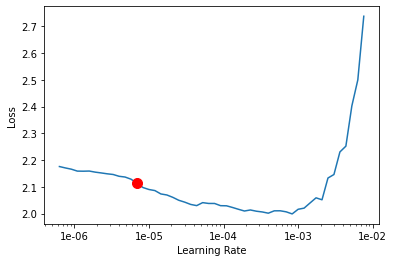

In [61]:
learner.recorder.plot(skip_end=10,suggestion=True)

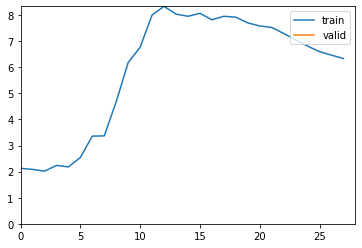

In [62]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

In [63]:
learner.save('first_cycle')

In [64]:
seed_all(seed)
learner.load('first_cycle');

In [65]:
learner.freeze_to(-2)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [66]:
lr = 1e-5

In [71]:
learner.predict('80 financial institutions ai key competitive driver success study reveals')

(Category tensor(0),
 tensor(0),
 tensor([3.8644e-01, 9.3464e-05, 7.6035e-04, 1.5454e-01, 1.8257e-07, 1.8561e-01,
         2.7256e-01, 3.2858e-09]))